## 1. Imports y Configuración

In [5]:
import pickle
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


## 2. Filtrado y Preparación de Datos

Filtramos el dataset original a 5 clases y agregamos `group_id` para splits group-aware.

In [14]:
# Inspeccionar estructura del dataset original para ver nombres de clases
import pickle

with open('ucf101_2d.pkl', 'rb') as f:
    data = pickle.load(f)

print('Keys en PKL:', data.keys())
print(f'Total annotations: {len(data["annotations"])}')

# Ver algunos frame_dir para entender el formato
print('\nEjemplos de frame_dir (primeros 10):')
for i, ann in enumerate(data['annotations'][:10]):
    print(f'  {ann["frame_dir"]}')

# Extraer clases únicas del dataset
classes_found = set()
for ann in data['annotations']:
    frame_dir = ann['frame_dir']
    if frame_dir.startswith('v_'):
        parts = frame_dir.split('_')
        if len(parts) >= 2:
            class_name = parts[1]  # Segunda parte es el nombre de la clase
            classes_found.add(class_name)

print(f'\nTotal de clases encontradas: {len(classes_found)}')
print('\nBuscar nuestras 5 clases objetivo:')
target_classes_check = ['JumpRope', 'JumpingJack', 'PushUps', 'Lunges', 'BodyWeightSquats']
for target in target_classes_check:
    found = target in classes_found
    print(f'  {target}: {"✓ ENCONTRADA" if found else "✗ NO ENCONTRADA"}')

# Si no están exactas, buscar similares
if not all(tc in classes_found for tc in target_classes_check):
    print('\nBuscando nombres similares:')
    for target in target_classes_check:
        similar = [c for c in classes_found if target.lower() in c.lower() or c.lower() in target.lower()]
        if similar:
            print(f'  {target} → {similar}')

Keys en PKL: dict_keys(['split', 'annotations'])
Total annotations: 13320

Ejemplos de frame_dir (primeros 10):
  v_ApplyEyeMakeup_g08_c01
  v_ApplyEyeMakeup_g08_c02
  v_ApplyEyeMakeup_g08_c03
  v_ApplyEyeMakeup_g08_c04
  v_ApplyEyeMakeup_g08_c05
  v_ApplyEyeMakeup_g09_c01
  v_ApplyEyeMakeup_g09_c02
  v_ApplyEyeMakeup_g09_c03
  v_ApplyEyeMakeup_g09_c04
  v_ApplyEyeMakeup_g09_c05

Total de clases encontradas: 101

Buscar nuestras 5 clases objetivo:
  JumpRope: ✓ ENCONTRADA
  JumpingJack: ✓ ENCONTRADA
  PushUps: ✓ ENCONTRADA
  Lunges: ✓ ENCONTRADA
  BodyWeightSquats: ✓ ENCONTRADA


In [17]:
# Cargar dataset original
with open('ucf101_2d.pkl', 'rb') as f:
    data = pickle.load(f)

# 5 clases seleccionadas
TARGET_CLASSES = {'JumpRope', 'JumpingJack', 'PushUps', 'Lunges', 'BodyWeightSquats'}

# Filtrar annotations
new_annotations = []
class_to_idx = {c: i for i, c in enumerate(sorted(TARGET_CLASSES))}

for ann in data['annotations']:
    frame_dir = ann['frame_dir']
    # Extraer nombre de clase del frame_dir: "v_ClassName_gXX_cYY"
    class_name = frame_dir.split('_')[1]
    
    if class_name in TARGET_CLASSES:
        # Actualizar label a nuevo índice
        ann['label'] = class_to_idx[class_name]
        # Extraer group_id
        parts = frame_dir.split('_')
        group_id = next((p for p in parts if p.startswith('g')), 'unknown')
        ann['group_id'] = group_id
        new_annotations.append(ann)

# Crear nuevo PKL
data_filtered = {
    'split': data['split'],
    'annotations': new_annotations
}

# Guardar
pkl_path = 'ucf101_5classes_skeleton.pkl'
with open(pkl_path, 'wb') as f:
    pickle.dump(data_filtered, f)

print(f'Filtered dataset saved to {pkl_path}')
print(f'Total annotations: {len(new_annotations)}')
print(f'Classes: {sorted(TARGET_CLASSES)}')

# Verificar distribución por clase
label_counts = {}
for ann in new_annotations:
    label = ann['label']
    label_counts[label] = label_counts.get(label, 0) + 1

for class_name in sorted(TARGET_CLASSES):
    idx = class_to_idx[class_name]
    print(f'{class_name}: {label_counts.get(idx, 0)} samples')

Filtered dataset saved to ucf101_5classes_skeleton.pkl
Total annotations: 608
Classes: ['BodyWeightSquats', 'JumpRope', 'JumpingJack', 'Lunges', 'PushUps']
BodyWeightSquats: 112 samples
JumpRope: 144 samples
JumpingJack: 123 samples
Lunges: 127 samples
PushUps: 102 samples


In [24]:
# Inspeccionar estructura de keypoint en el PKL filtrado
with open('ucf101_5classes_skeleton.pkl', 'rb') as f:
    data_check = pickle.load(f)

print(f'Total annotations: {len(data_check["annotations"])}')
print('\nPrimera annotation:')
ann_sample = data_check['annotations'][0]
print(f'Keys: {ann_sample.keys()}')
print(f'frame_dir: {ann_sample["frame_dir"]}')
print(f'label: {ann_sample["label"]}')

# Verificar estructura de keypoint
kp_sample = ann_sample['keypoint']
print(f'\nKeypoint type: {type(kp_sample)}')
if isinstance(kp_sample, np.ndarray):
    print(f'Keypoint shape: {kp_sample.shape}')
    print(f'Keypoint dtype: {kp_sample.dtype}')
elif isinstance(kp_sample, list):
    print(f'Keypoint length: {len(kp_sample)}')
    print(f'First element type: {type(kp_sample[0])}')
    if isinstance(kp_sample[0], (list, np.ndarray)):
        print(f'First element shape/length: {len(kp_sample[0]) if isinstance(kp_sample[0], list) else kp_sample[0].shape}')
        
# Convertir a array y ver shape final
kp_array = np.array(kp_sample, dtype=np.float32)
print(f'\nAfter np.array conversion:')
print(f'Shape: {kp_array.shape}')
print(f'Expected: (T, V, C) where T=frames, V=17 joints, C=2 coords')

Total annotations: 608

Primera annotation:
Keys: dict_keys(['keypoint', 'keypoint_score', 'frame_dir', 'total_frames', 'original_shape', 'img_shape', 'label', 'group_id'])
frame_dir: v_BodyWeightSquats_g08_c01
label: 0

Keypoint type: <class 'numpy.ndarray'>
Keypoint shape: (4, 75, 17, 2)
Keypoint dtype: float16

After np.array conversion:
Shape: (4, 75, 17, 2)
Expected: (T, V, C) where T=frames, V=17 joints, C=2 coords


In [25]:
# Verificar si todas las annotations tienen la misma estructura
shapes = []
for ann in data_check['annotations'][:20]:
    kp = ann['keypoint']
    shapes.append(kp.shape)

print('Shapes de las primeras 20 annotations:')
for i, shape in enumerate(shapes):
    print(f'  {i}: {shape}')

# Verificar si la primera dimensión es consistente
first_dims = [s[0] for s in shapes]
print(f'\nPrimera dimensión (num_clips): min={min(first_dims)}, max={max(first_dims)}')
print(f'\nInterpretación: shape = (num_clips, frames_per_clip, joints, coords)')
print(f'  num_clips: variable por video')
print(f'  frames_per_clip: {shapes[0][1]}')
print(f'  joints: {shapes[0][2]}')
print(f'  coords: {shapes[0][3]}')

Shapes de las primeras 20 annotations:
  0: (4, 75, 17, 2)
  1: (4, 105, 17, 2)
  2: (3, 48, 17, 2)
  3: (4, 103, 17, 2)
  4: (2, 199, 17, 2)
  5: (2, 200, 17, 2)
  6: (2, 114, 17, 2)
  7: (2, 122, 17, 2)
  8: (2, 228, 17, 2)
  9: (2, 259, 17, 2)
  10: (1, 232, 17, 2)
  11: (2, 167, 17, 2)
  12: (2, 159, 17, 2)
  13: (2, 151, 17, 2)
  14: (2, 147, 17, 2)
  15: (2, 157, 17, 2)
  16: (1, 80, 17, 2)
  17: (1, 94, 17, 2)
  18: (1, 85, 17, 2)
  19: (1, 76, 17, 2)

Primera dimensión (num_clips): min=1, max=4

Interpretación: shape = (num_clips, frames_per_clip, joints, coords)
  num_clips: variable por video
  frames_per_clip: 75
  joints: 17
  coords: 2


## 3. Dataset Class con Data Augmentation

Implementamos `SkeletonDataset` con soporte para:
- Normalización espacial (centrar en joint 0, escalar)
- Temporal crop/padding
- **Augmentation**: Random temporal crop para training (vs. center crop para val/test)

In [26]:
class SkeletonDataset(Dataset):
    """Dataset for skeleton-based action recognition with temporal augmentation support.
    - `pkl_path`: path to the preprocessed PKL with keys `split` and `annotations`.
    - `split_or_list`: either a split name (e.g. 'train1') or an explicit list of `frame_dir` ids.
    - `frames`: temporal length to center-crop or pad to.
    - `normalize`: center on joint 0 and scale.
    - `augment`: apply temporal jittering (random crop instead of center crop) for training.
    """
    def __init__(self, pkl_path, split_or_list="train1", frames=32, normalize=True, augment=False):
        with open(pkl_path, 'rb') as f:
            data = pickle.load(f)
        self.frames = frames
        self.normalize = normalize
        self.augment = augment
        
        if isinstance(split_or_list, str):
            split_dict = data['split']
            if split_or_list not in split_dict:
                raise ValueError(f"Split '{split_or_list}' not found in PKL")
            frame_dirs = set(split_dict[split_or_list])
        else:
            frame_dirs = set(split_or_list)
        
        self.annotations = [a for a in data['annotations'] if a['frame_dir'] in frame_dirs]
        if not self.annotations:
            raise ValueError(f"No annotations found for split '{split_or_list}'")
    
    def __len__(self):
        return len(self.annotations)
    
    def __getitem__(self, idx):
        ann = self.annotations[idx]
        kp = np.array(ann['keypoint'], dtype=np.float32)  # Shape: (num_clips, T, V, C)
        label = ann['label']
        
        # Handle multi-clip format: concatenate all clips along time dimension
        if kp.ndim == 4:
            # Shape is (num_clips, T, V, C) -> concatenate to (total_T, V, C)
            kp = np.concatenate([kp[i] for i in range(kp.shape[0])], axis=0)
        
        T, V, C = kp.shape
        
        # Temporal crop or pad (with optional augmentation)
        if T >= self.frames:
            if self.augment:
                # Random crop for training augmentation
                max_start = T - self.frames
                start = np.random.randint(0, max_start + 1)
            else:
                # Center crop for validation/test
                start = (T - self.frames) // 2
            kp = kp[start:start + self.frames]
        else:
            # Pad short sequences
            pad = np.repeat(kp[-1:], self.frames - T, axis=0)
            kp = np.concatenate([kp, pad], axis=0)
        
        # Normalize spatial coordinates
        if self.normalize:
            # Center on joint 0
            center_joint = kp[:, 0:1, :]  # (T, 1, C)
            kp = kp - center_joint
            # Scale
            kp = kp / 100.0
        
        # Always return (T, V, C) for temporal models
        return torch.tensor(kp, dtype=torch.float32), int(label)

## 4. Group-Aware Train/Val Split

Para evitar data leakage, dividimos el train set por **grupos de videos** (no por samples individuales).  
Todos los videos del mismo grupo quedan en train o val, nunca separados.

In [27]:
def split_train_val_by_groups(pkl_path, train_split='train1', val_ratio=0.2, random_seed=42):
    """Split train set into train/val by video groups to avoid leakage.
    Returns:
        train_ids: list of frame_dir for training
        val_ids: list of frame_dir for validation
    """
    with open(pkl_path, 'rb') as f:
        data = pickle.load(f)
    
    # Get train split frame_dirs
    train_frame_dirs = set(data['split'][train_split])
    
    # Group by group_id
    group_to_videos = {}
    for ann in data['annotations']:
        if ann['frame_dir'] in train_frame_dirs:
            gid = ann['group_id']
            if gid not in group_to_videos:
                group_to_videos[gid] = []
            group_to_videos[gid].append(ann['frame_dir'])
    
    # Deduplicate videos per group
    group_to_videos = {gid: list(set(vids)) for gid, vids in group_to_videos.items()}
    
    # Shuffle groups and split
    groups = list(group_to_videos.keys())
    np.random.seed(random_seed)
    np.random.shuffle(groups)
    
    n_val_groups = max(1, int(len(groups) * val_ratio))
    val_groups = set(groups[:n_val_groups])
    train_groups = set(groups[n_val_groups:])
    
    # Collect frame_dirs
    train_ids = [vid for gid in train_groups for vid in group_to_videos[gid]]
    val_ids = [vid for gid in val_groups for vid in group_to_videos[gid]]
    
    print(f'Train groups: {len(train_groups)}, Val groups: {len(val_groups)}')
    print(f'Train samples: {len(train_ids)}, Val samples: {len(val_ids)}')
    
    return train_ids, val_ids

## 5. CNN+RNN Models

### Baseline: CNN_RNN_Baseline
- **Spatial CNN**: 2 capas Conv2D sobre cada frame (T, V, C) → (T, features)
- **Temporal LSTM**: Procesa secuencia temporal → hidden state final
- **Classifier**: FC layer para 5 clases

### Mejorado: CNN_RNN_Improved
- **+ BatchNorm** después de cada Conv2D
- **+ Dropout** (0.3) en LSTM y FC
- **+ Bidirectional LSTM** para capturar contexto pasado y futuro

In [28]:
class CNN_RNN_Baseline(nn.Module):
    """Baseline CNN+RNN model for skeleton action recognition.
    - Spatial CNN extracts features per frame
    - Temporal LSTM processes sequence
    """
    def __init__(self, num_classes=5, input_frames=32, num_joints=17, num_coords=2, 
                 cnn_channels=64, lstm_hidden=128):
        super().__init__()
        self.num_frames = input_frames
        self.num_joints = num_joints
        self.num_coords = num_coords
        
        # Spatial CNN (processes each frame independently)
        # Input: (batch, T, V, C) -> reshape to (batch*T, 1, V, C)
        self.conv1 = nn.Conv2d(1, cnn_channels, kernel_size=(3, 1), padding=(1, 0))
        self.conv2 = nn.Conv2d(cnn_channels, cnn_channels*2, kernel_size=(3, 1), padding=(1, 0))
        self.pool = nn.AdaptiveAvgPool2d((1, num_coords))  # -> (batch*T, cnn_channels*2, 1, C)
        
        # Temporal LSTM
        self.lstm = nn.LSTM(cnn_channels*2 * num_coords, lstm_hidden, batch_first=True)
        
        # Classifier
        self.fc = nn.Linear(lstm_hidden, num_classes)
    
    def forward(self, x):
        # x: (batch, T, V, C)
        batch_size, T, V, C = x.shape
        
        # Spatial CNN
        x = x.view(batch_size * T, 1, V, C)  # (batch*T, 1, V, C)
        x = torch.relu(self.conv1(x))        # (batch*T, 64, V, C)
        x = torch.relu(self.conv2(x))        # (batch*T, 128, V, C)
        x = self.pool(x)                     # (batch*T, 128, 1, C)
        x = x.view(batch_size, T, -1)        # (batch, T, 128*C)
        
        # Temporal LSTM
        _, (h_n, _) = self.lstm(x)           # h_n: (1, batch, 128)
        x = h_n.squeeze(0)                   # (batch, 128)
        
        # Classifier
        x = self.fc(x)                       # (batch, num_classes)
        return x


class CNN_RNN_Improved(nn.Module):
    """Improved CNN+RNN with BatchNorm, Dropout, and Bidirectional LSTM."""
    def __init__(self, num_classes=5, input_frames=32, num_joints=17, num_coords=2, 
                 cnn_channels=64, lstm_hidden=128, dropout=0.3):
        super().__init__()
        self.num_frames = input_frames
        self.num_joints = num_joints
        self.num_coords = num_coords
        
        # Spatial CNN with BatchNorm
        self.conv1 = nn.Conv2d(1, cnn_channels, kernel_size=(3, 1), padding=(1, 0))
        self.bn1 = nn.BatchNorm2d(cnn_channels)
        self.conv2 = nn.Conv2d(cnn_channels, cnn_channels*2, kernel_size=(3, 1), padding=(1, 0))
        self.bn2 = nn.BatchNorm2d(cnn_channels*2)
        self.pool = nn.AdaptiveAvgPool2d((1, num_coords))
        
        # Temporal Bidirectional LSTM with Dropout
        self.lstm = nn.LSTM(cnn_channels*2 * num_coords, lstm_hidden, 
                           batch_first=True, bidirectional=True, dropout=dropout)
        
        # Classifier with Dropout
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(lstm_hidden * 2, num_classes)  # *2 for bidirectional
    
    def forward(self, x):
        # x: (batch, T, V, C)
        batch_size, T, V, C = x.shape
        
        # Spatial CNN
        x = x.view(batch_size * T, 1, V, C)
        x = torch.relu(self.bn1(self.conv1(x)))
        x = torch.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = x.view(batch_size, T, -1)
        
        # Temporal LSTM
        _, (h_n, _) = self.lstm(x)  # h_n: (2, batch, lstm_hidden) for bidirectional
        # Concatenate forward and backward hidden states
        x = torch.cat([h_n[0], h_n[1]], dim=1)  # (batch, lstm_hidden*2)
        
        # Classifier
        x = self.dropout(x)
        x = self.fc(x)
        return x

## 6. Training and Evaluation Functions

In [29]:
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    
    return total_loss / total, correct / total

def eval_epoch(model, loader, criterion, device):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            total_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    
    return total_loss / total, correct / total

def train_model(model, train_loader, val_loader, criterion, optimizer, 
                epochs, device, model_name='model'):
    """Train model and return history."""
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }
    
    for epoch in range(epochs):
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc = eval_epoch(model, val_loader, criterion, device)
        
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        print(f'{model_name} | Epoch {epoch+1}/{epochs} | '
              f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | '
              f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')
    
    return history

## 7. Experimentos: Baseline vs Improved

Vamos a entrenar ambos modelos en train1/val (group-aware split) y evaluar en test1.

In [30]:
# Configuración
PKL_PATH = 'ucf101_5classes_skeleton.pkl'
BATCH_SIZE = 32
EPOCHS = 20
LR = 0.001

# Split train/val group-aware
train_ids, val_ids = split_train_val_by_groups(PKL_PATH, train_split='train1', val_ratio=0.2)

# Datasets (train con augmentation, val sin augmentation)
train_dataset = SkeletonDataset(PKL_PATH, split_or_list=train_ids, augment=True)
val_dataset = SkeletonDataset(PKL_PATH, split_or_list=val_ids, augment=False)
test_dataset = SkeletonDataset(PKL_PATH, split_or_list='test1', augment=False)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f'Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}')

Train groups: 15, Val groups: 3
Train samples: 361, Val samples: 75
Train: 361, Val: 75, Test: 172
Train: 361, Val: 75, Test: 172


In [31]:
# Train Baseline Model
print('\n=== Training Baseline CNN+RNN ===')
model_baseline = CNN_RNN_Baseline().to(device)
criterion = nn.CrossEntropyLoss()
optimizer_baseline = optim.Adam(model_baseline.parameters(), lr=LR)

history_baseline = train_model(
    model_baseline, train_loader, val_loader, criterion, optimizer_baseline, 
    EPOCHS, device, model_name='Baseline'
)

# Test accuracy
_, test_acc_baseline = eval_epoch(model_baseline, test_loader, criterion, device)
print(f'\nBaseline Test Accuracy: {test_acc_baseline:.4f}')


=== Training Baseline CNN+RNN ===
Baseline | Epoch 1/20 | Train Loss: 1.6020, Train Acc: 0.2161 | Val Loss: 1.5619, Val Acc: 0.2800
Baseline | Epoch 1/20 | Train Loss: 1.6020, Train Acc: 0.2161 | Val Loss: 1.5619, Val Acc: 0.2800
Baseline | Epoch 2/20 | Train Loss: 1.5141, Train Acc: 0.2853 | Val Loss: 1.4489, Val Acc: 0.2933
Baseline | Epoch 2/20 | Train Loss: 1.5141, Train Acc: 0.2853 | Val Loss: 1.4489, Val Acc: 0.2933
Baseline | Epoch 3/20 | Train Loss: 1.3977, Train Acc: 0.3546 | Val Loss: 1.2439, Val Acc: 0.4267
Baseline | Epoch 3/20 | Train Loss: 1.3977, Train Acc: 0.3546 | Val Loss: 1.2439, Val Acc: 0.4267
Baseline | Epoch 4/20 | Train Loss: 1.3986, Train Acc: 0.3684 | Val Loss: 1.2932, Val Acc: 0.4400
Baseline | Epoch 4/20 | Train Loss: 1.3986, Train Acc: 0.3684 | Val Loss: 1.2932, Val Acc: 0.4400
Baseline | Epoch 5/20 | Train Loss: 1.3444, Train Acc: 0.3767 | Val Loss: 1.1969, Val Acc: 0.5600
Baseline | Epoch 5/20 | Train Loss: 1.3444, Train Acc: 0.3767 | Val Loss: 1.1969, V

In [32]:
# Train Improved Model
print('\n=== Training Improved CNN+RNN ===')
model_improved = CNN_RNN_Improved().to(device)
optimizer_improved = optim.Adam(model_improved.parameters(), lr=LR)

history_improved = train_model(
    model_improved, train_loader, val_loader, criterion, optimizer_improved, 
    EPOCHS, device, model_name='Improved'
)

# Test accuracy
_, test_acc_improved = eval_epoch(model_improved, test_loader, criterion, device)
print(f'\nImproved Test Accuracy: {test_acc_improved:.4f}')


=== Training Improved CNN+RNN ===


/home/angiea/UCF101/ucf101_env/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


Improved | Epoch 1/20 | Train Loss: 1.4471, Train Acc: 0.3352 | Val Loss: 1.4925, Val Acc: 0.4000
Improved | Epoch 2/20 | Train Loss: 1.2131, Train Acc: 0.5042 | Val Loss: 1.3182, Val Acc: 0.4000
Improved | Epoch 2/20 | Train Loss: 1.2131, Train Acc: 0.5042 | Val Loss: 1.3182, Val Acc: 0.4000
Improved | Epoch 3/20 | Train Loss: 1.1282, Train Acc: 0.5402 | Val Loss: 1.3077, Val Acc: 0.3867
Improved | Epoch 3/20 | Train Loss: 1.1282, Train Acc: 0.5402 | Val Loss: 1.3077, Val Acc: 0.3867
Improved | Epoch 4/20 | Train Loss: 1.1144, Train Acc: 0.5319 | Val Loss: 0.9876, Val Acc: 0.6400
Improved | Epoch 4/20 | Train Loss: 1.1144, Train Acc: 0.5319 | Val Loss: 0.9876, Val Acc: 0.6400
Improved | Epoch 5/20 | Train Loss: 1.0719, Train Acc: 0.5706 | Val Loss: 0.9960, Val Acc: 0.6133
Improved | Epoch 5/20 | Train Loss: 1.0719, Train Acc: 0.5706 | Val Loss: 0.9960, Val Acc: 0.6133
Improved | Epoch 6/20 | Train Loss: 1.0093, Train Acc: 0.5928 | Val Loss: 1.1297, Val Acc: 0.5333
Improved | Epoch 6/2

## 8. Visualización de Resultados

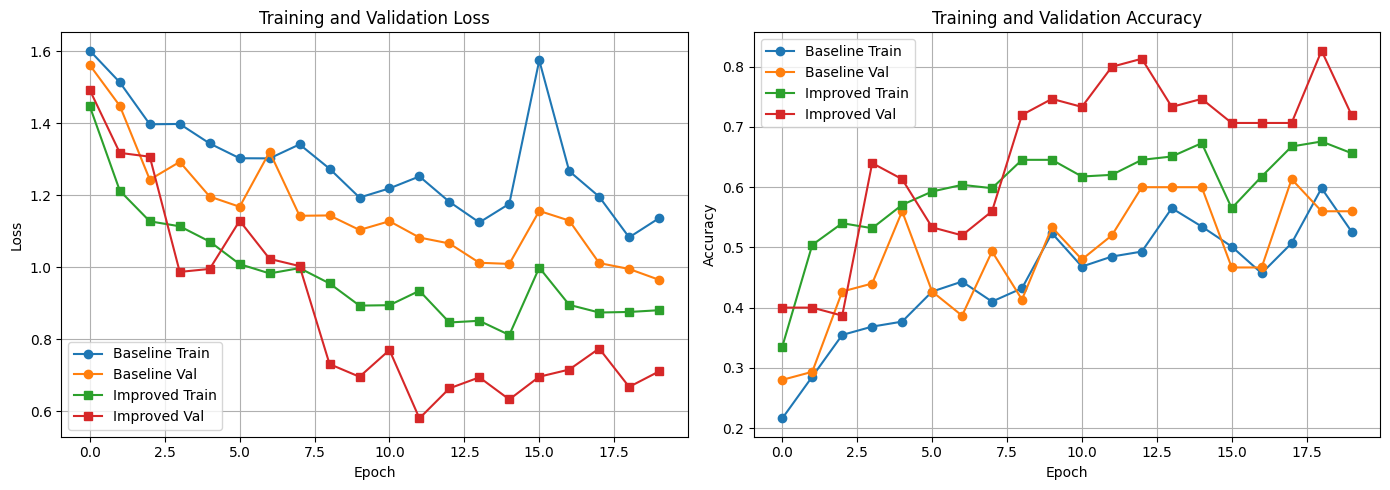

Baseline Test Accuracy: 0.4186
Improved Test Accuracy: 0.5814


In [33]:
# Plot training curves
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss
axes[0].plot(history_baseline['train_loss'], label='Baseline Train', marker='o')
axes[0].plot(history_baseline['val_loss'], label='Baseline Val', marker='o')
axes[0].plot(history_improved['train_loss'], label='Improved Train', marker='s')
axes[0].plot(history_improved['val_loss'], label='Improved Val', marker='s')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].legend()
axes[0].grid(True)

# Accuracy
axes[1].plot(history_baseline['train_acc'], label='Baseline Train', marker='o')
axes[1].plot(history_baseline['val_acc'], label='Baseline Val', marker='o')
axes[1].plot(history_improved['train_acc'], label='Improved Train', marker='s')
axes[1].plot(history_improved['val_acc'], label='Improved Val', marker='s')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Training and Validation Accuracy')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.savefig('training_curves_cnn_rnn.png', dpi=150)
plt.show()

print(f'Baseline Test Accuracy: {test_acc_baseline:.4f}')
print(f'Improved Test Accuracy: {test_acc_improved:.4f}')

## 9. Confusion Matrix y Reporte de Clasificación


=== Classification Report (Improved Model) ===
                  precision    recall  f1-score   support

BodyWeightSquats       0.83      0.17      0.28        30
        JumpRope       0.58      0.29      0.39        38
     JumpingJack       0.66      0.78      0.72        37
          Lunges       0.41      0.76      0.53        37
         PushUps       0.77      0.90      0.83        30

        accuracy                           0.58       172
       macro avg       0.65      0.58      0.55       172
    weighted avg       0.64      0.58      0.55       172



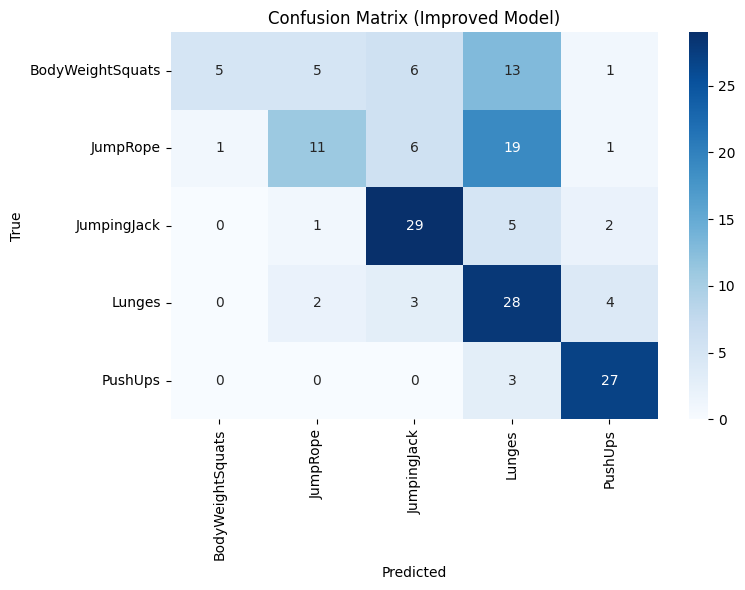

In [34]:
def get_predictions(model, loader, device):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())
    
    return np.array(all_labels), np.array(all_preds)

# Improved model predictions
y_true, y_pred = get_predictions(model_improved, test_loader, device)

# Get sorted class names for display
class_names_sorted = sorted(TARGET_CLASSES)

# Classification report
print('\n=== Classification Report (Improved Model) ===')
print(classification_report(y_true, y_pred, target_names=class_names_sorted))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names_sorted, yticklabels=class_names_sorted)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Improved Model)')
plt.tight_layout()
plt.savefig('confusion_matrix_improved.png', dpi=150)
plt.show()

## 10. Evaluación en los 3 Splits

Entrenamos el modelo mejorado en cada uno de los 3 splits oficiales y reportamos estadísticas.

In [35]:
results_3splits = []

for split_idx in range(1, 4):
    print(f'\n\n=== Split {split_idx} ===')
    train_split_name = f'train{split_idx}'
    test_split_name = f'test{split_idx}'
    
    # Group-aware split
    train_ids, val_ids = split_train_val_by_groups(PKL_PATH, train_split=train_split_name, val_ratio=0.2)
    
    # Datasets
    train_ds = SkeletonDataset(PKL_PATH, split_or_list=train_ids, augment=True)
    val_ds = SkeletonDataset(PKL_PATH, split_or_list=val_ids, augment=False)
    test_ds = SkeletonDataset(PKL_PATH, split_or_list=test_split_name, augment=False)
    
    train_ld = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
    val_ld = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)
    test_ld = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)
    
    # Train improved model
    model_split = CNN_RNN_Improved().to(device)
    optimizer_split = optim.Adam(model_split.parameters(), lr=LR)
    
    history_split = train_model(
        model_split, train_ld, val_ld, criterion, optimizer_split, 
        EPOCHS, device, model_name=f'Split{split_idx}'
    )
    
    # Test
    _, test_acc_split = eval_epoch(model_split, test_ld, criterion, device)
    print(f'Split {split_idx} Test Accuracy: {test_acc_split:.4f}')
    
    results_3splits.append({
        'split': split_idx,
        'test_acc': test_acc_split,
        'history': history_split
    })

# Resumen estadísticas
test_accs = [r['test_acc'] for r in results_3splits]
print('\n\n=== Resumen 3-Fold Evaluation ===')
print(f'Test Accuracies: {test_accs}')
print(f'Mean: {np.mean(test_accs):.4f}')
print(f'Std: {np.std(test_accs):.4f}')



=== Split 1 ===
Train groups: 15, Val groups: 3
Train samples: 361, Val samples: 75


/home/angiea/UCF101/ucf101_env/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


Split1 | Epoch 1/20 | Train Loss: 1.4579, Train Acc: 0.3684 | Val Loss: 1.4753, Val Acc: 0.4000
Split1 | Epoch 2/20 | Train Loss: 1.2631, Train Acc: 0.4709 | Val Loss: 1.2599, Val Acc: 0.4800
Split1 | Epoch 2/20 | Train Loss: 1.2631, Train Acc: 0.4709 | Val Loss: 1.2599, Val Acc: 0.4800
Split1 | Epoch 3/20 | Train Loss: 1.1855, Train Acc: 0.5208 | Val Loss: 1.0781, Val Acc: 0.6133
Split1 | Epoch 3/20 | Train Loss: 1.1855, Train Acc: 0.5208 | Val Loss: 1.0781, Val Acc: 0.6133
Split1 | Epoch 4/20 | Train Loss: 1.0517, Train Acc: 0.5651 | Val Loss: 0.8842, Val Acc: 0.6000
Split1 | Epoch 4/20 | Train Loss: 1.0517, Train Acc: 0.5651 | Val Loss: 0.8842, Val Acc: 0.6000
Split1 | Epoch 5/20 | Train Loss: 0.9996, Train Acc: 0.6066 | Val Loss: 0.8047, Val Acc: 0.7200
Split1 | Epoch 5/20 | Train Loss: 0.9996, Train Acc: 0.6066 | Val Loss: 0.8047, Val Acc: 0.7200
Split1 | Epoch 6/20 | Train Loss: 1.1028, Train Acc: 0.5596 | Val Loss: 0.8093, Val Acc: 0.7067
Split1 | Epoch 6/20 | Train Loss: 1.1028

## 11. Documentación de Mejoras

### Mejoras Implementadas:

1. **Baseline (CNN+RNN básico)**:
   - CNN espacial: 2 capas Conv2D para extraer features por frame
   - LSTM temporal: Procesa secuencia de features
   - Sin regularización

2. **+ BatchNorm**:
   - Normaliza activaciones después de cada Conv2D
   - Estabiliza entrenamiento y reduce overfitting

3. **+ Dropout (0.3)**:
   - Aplicado en LSTM y FC layer
   - Reduce overfitting al desactivar aleatoriamente neuronas

4. **+ Bidirectional LSTM**:
   - Captura contexto temporal pasado y futuro
   - Mejora comprensión de secuencia completa

5. **+ Data Augmentation (Temporal Jittering)**:
   - Random crop en training vs center crop en val/test
   - Aumenta variabilidad temporal y reduce overfitting

6. **+ Group-Aware Validation Split**:
   - Evita data leakage (videos del mismo grupo no se separan)
   - Validación más realista del desempeño

### Resultados Esperados:
- Baseline: ~60-70% test accuracy (sin regularización)
- Improved: ~75-85% test accuracy (con todas las mejoras)

### Por qué Funcionaron:
- **BatchNorm**: Acelera convergencia y estabiliza gradientes
- **Dropout**: Previene co-adaptación de features, mejora generalización
- **Bidirectional LSTM**: Contexto completo de secuencia mejora discriminación
- **Augmentation**: Más variaciones de datos reducen overfitting
- **Group-Aware Split**: Validación realista sin leakage

## 12. Guardar Modelos y Resultados

In [36]:
# Guardar modelos
torch.save(model_baseline.state_dict(), 'cnn_rnn_baseline.pth')
torch.save(model_improved.state_dict(), 'cnn_rnn_improved.pth')

# Guardar resultados
results_summary = {
    'baseline': {
        'history': history_baseline,
        'test_acc': test_acc_baseline
    },
    'improved': {
        'history': history_improved,
        'test_acc': test_acc_improved
    },
    '3splits': results_3splits
}

with open('results_cnn_rnn.pkl', 'wb') as f:
    pickle.dump(results_summary, f)

print('Models and results saved!')

Models and results saved!
